# 誰でも手軽に医用画像処理

## 0.準備

In [ ]:
!git clone https://github.com/Tminor7/image-processing-playground.git

fatal: destination path 'image-processing-playground' already exists and is not an empty directory.


In [ ]:
!pip install SimpleITK

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 16.3 MB/s eta 0:00:00


In [1]:
import os
import glob
import PIL
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from IPython.display import display, Image

In [ ]:
os.chdir('image-processing-playground')

## 1.まずはファイルの確認
ChatGPTへの指示
>pythonでの医用画像処理を手伝ってください．“data > case01”フォルダの中に15枚のDICOMファイルがあります．これらを全て読み込んで，5枚ずつ3段で表示してください．画像の読み込みはSimpleITKを使ってください．

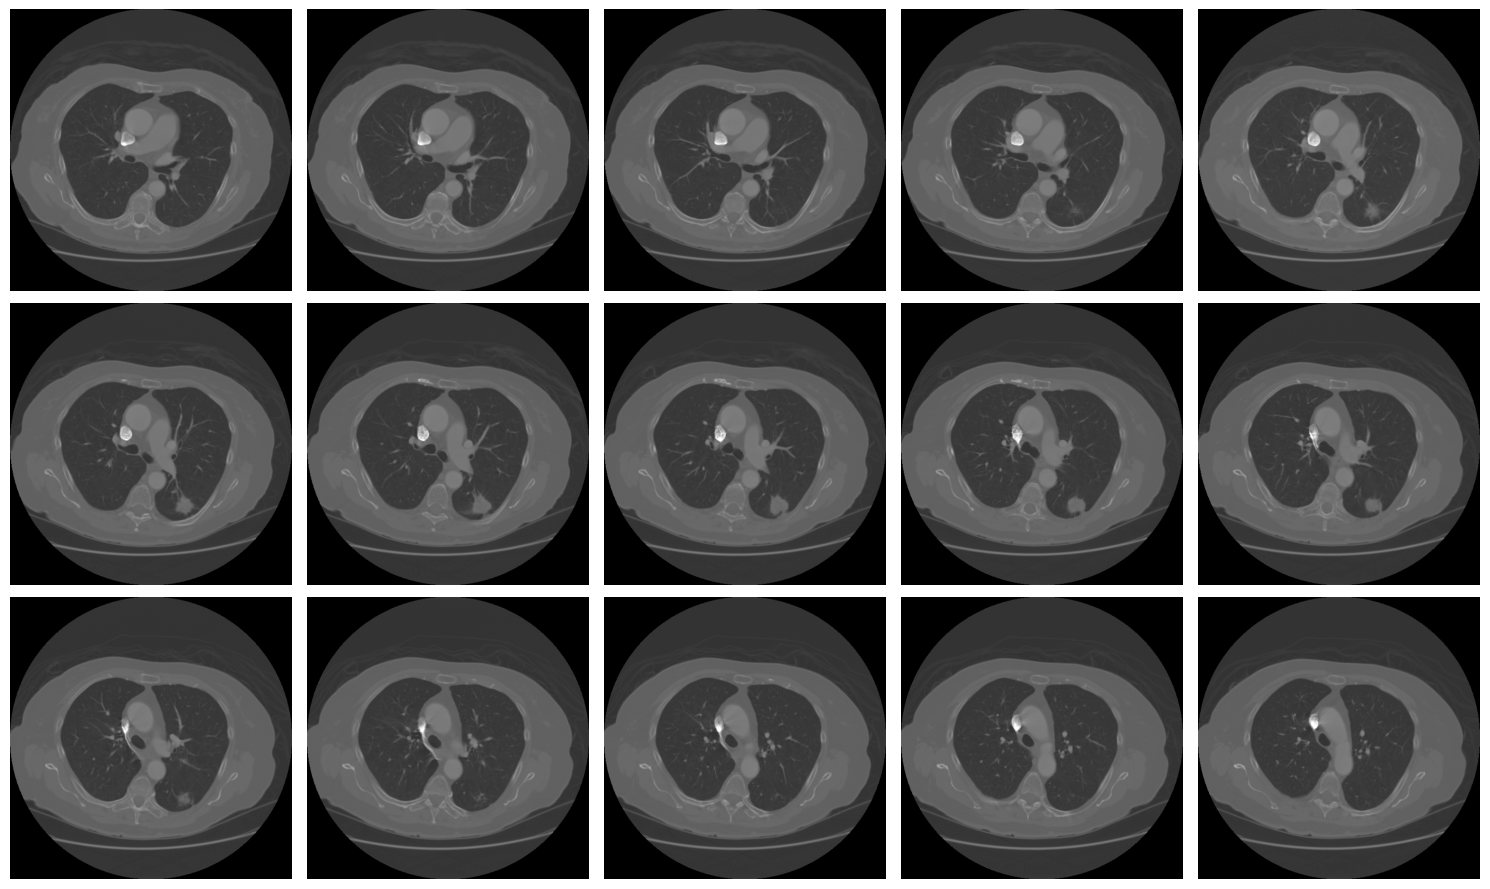

In [2]:
# DICOMファイルが保存されているディレクトリ
directory = "data/case01"

# ディレクトリ内のDICOMファイルを読み込む
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames(directory)
reader.SetFileNames(dicom_names)
images = reader.Execute()

# 画像を5枚ずつ3段で表示
plt.figure(figsize=(15, 9))
for i in range(15):
    # SimpleITKの画像をNumPy配列に変換
    image_array = sitk.GetArrayFromImage(images[:,:,i])
    
    # サブプロットに画像を表示
    plt.subplot(3, 5, i+1)
    plt.imshow(image_array, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()


## 2.jpegとして保存
ChatGPTへの指示
>表示された画像は胸部CTのようでした．肺野条件になるように適切にwindow levelとwidthを設定した上で，jpeg画像として保存してください．保存先はresultsフォルダとしてください．また，変換後の画像を先ほどと同様に5枚3段で表示してください．

In [3]:
os.makedirs('results', exist_ok=True)

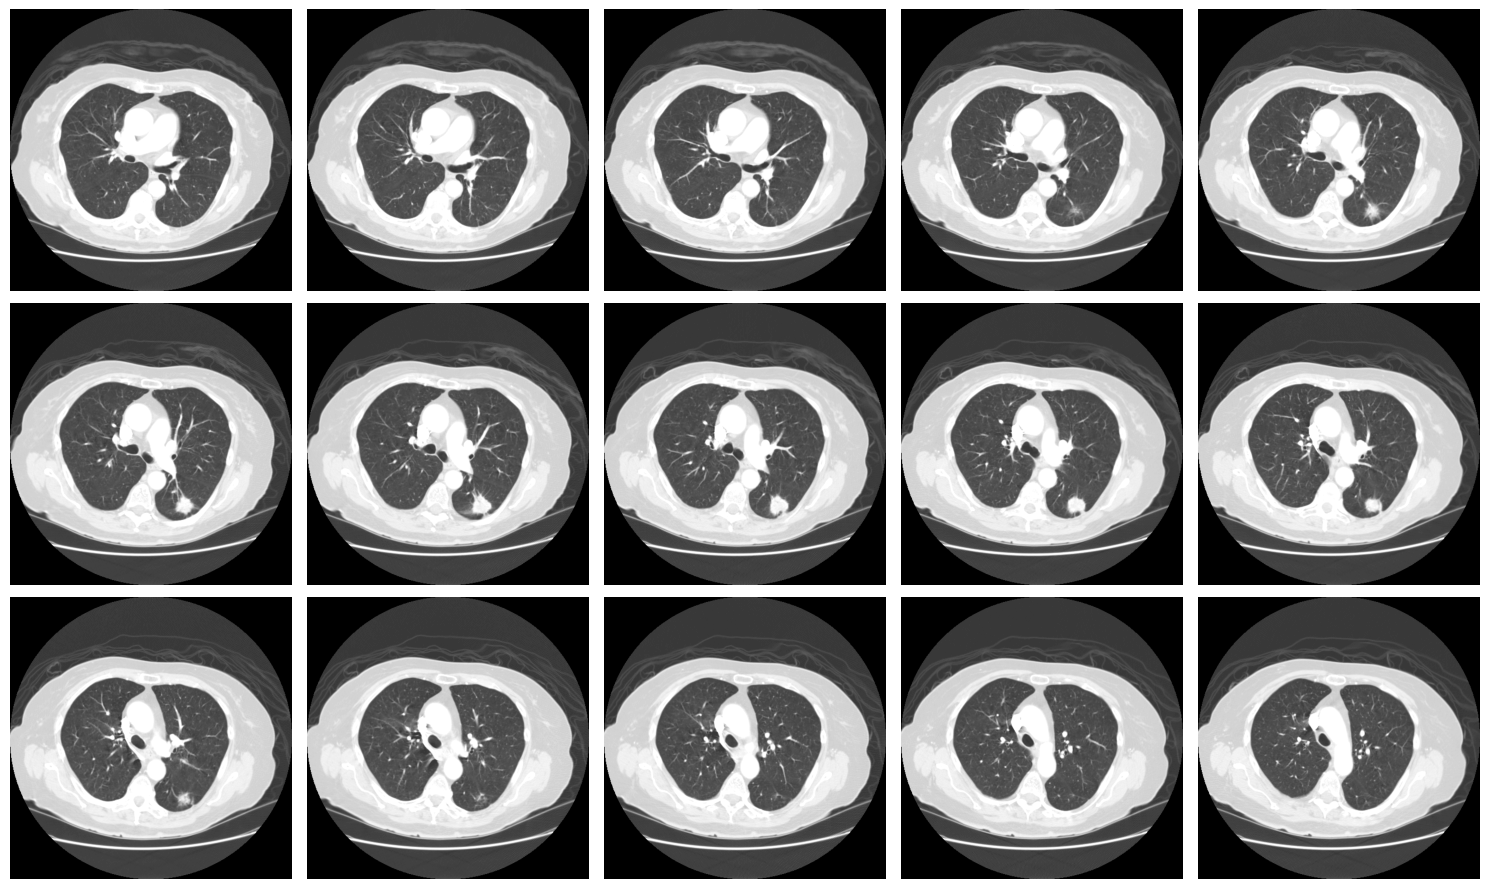

In [4]:
# ウィンドウレベルとウィンドウ幅の設定
window_level = -600  # 肺野のウィンドウレベル
window_width = 1500  # 肺野のウィンドウ幅

# 画像のウィンドウ処理関数
def windowing(image, level, width):
    lower = level - (width / 2)
    upper = level + (width / 2)
    image = np.clip(image, lower, upper)
    return (image - lower) / width

# 画像を処理し、JPEGとして保存し、表示
plt.figure(figsize=(15, 9))
for i in range(15):
    # SimpleITKの画像をNumPy配列に変換
    image_array = sitk.GetArrayFromImage(images[:,:,i])

    # ウィンドウ処理
    windowed_image = windowing(image_array, window_level, window_width)

    # JPEGとして保存
    plt.imsave(f"results/image_{i+1:02}.jpg", windowed_image, cmap='gray')

    # サブプロットに画像を表示
    plt.subplot(3, 5, i+1)
    plt.imshow(windowed_image, cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show()

## 3.動画ファイルの作成
>この15枚のjpegファイルを動画ファイルにしてください．フレームレートは4枚/秒にしてください．ファイル形式はgifでお願いします．作成されたファイルはresultsフォルダの中にmovie.gifとして保存してください．また，notebook上でも表示してください．

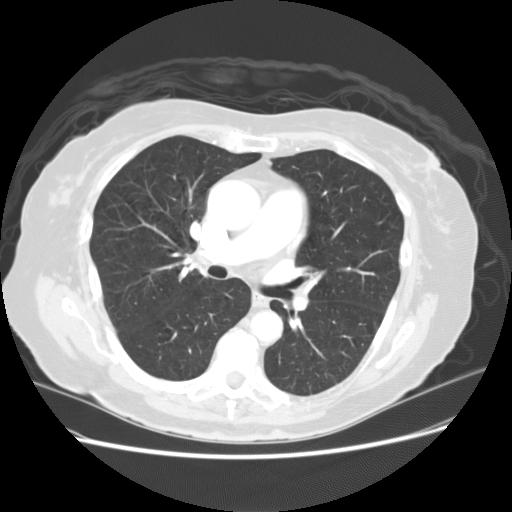

In [5]:
# "resultsフォルダ内のJPEGファイルを取得
jpeg_files = sorted(glob.glob('results/*.jpg'))

# 各JPEG画像を読み込み、GIFに変換
images = [PIL.Image.open(jpeg) for jpeg in jpeg_files]

# GIFファイルを作成し、保存
images[0].save(
    'results/4per1sec.gif',
    save_all=True,
    append_images=images[1:],
    duration=250,
    loop=0
    )

# GIFを表示
display(Image(filename='results/4per1sec.gif'))

## 4.高解像度化
ChatGPTへの指示
>今回用いた9番目の画像を高解像度化したいです．具体的には，300dpiで長辺が10cmになるようにしてください．また，変更の前後で縦横のpixel数がどう変化したかも教えてください．新しいファイルはresultsフォルダの中に，hr_image_09.jpgとして保存してください．

In [6]:
# 高解像度変換のためのパラメータ
dpi = 300  # 1インチあたりのドット数
target_length_cm = 10  # 目標の長さ（センチメートル）
target_length_inches = target_length_cm / 2.54  # センチメートルをインチに変換

# 9番目の画像を読み込む
image_09 = PIL.Image.open('results/image_09.jpg')

# 元の画像の寸法（ピクセル）
original_dimensions = image_09.size

# 新しい寸法を計算
# 長さが300dpiで10cmの場合、ピクセル数 = 300 * (10 / 2.54)
new_length = int(dpi * target_length_inches)
aspect_ratio = original_dimensions[0] / original_dimensions[1]

if original_dimensions[0] > original_dimensions[1]:  # 横長の場合
    new_dimensions = (new_length, int(new_length / aspect_ratio))
else:  # 縦長の場合
    new_dimensions = (int(new_length * aspect_ratio), new_length)

# 画像のリサイズ
image_09_hr = image_09.resize(new_dimensions, PIL.Image.Resampling.LANCZOS)

# 高解像度画像を保存
image_09_hr.save("results/hr_image_09.jpg")

print(f"元の画像サイズ: {original_dimensions[0]} x {original_dimensions[1]} ピクセル, ")
print(f"新しい画像サイズ: {new_dimensions[0]} x {new_dimensions[1]} ピクセル")

元の画像サイズ: 512 x 512 ピクセル, 
新しい画像サイズ: 1181 x 1181 ピクセル
